# Quick Code Analysis

To get going with this notebook I suggest using VS Code with Python extension.

Create a virtual environment in this folder:

```
python -m venv .venv
```

Select the Python Interpreter from the venv in the quick command menu (Ctrl/Cmd + Shift + P) -> `> Python: Select Interpreter` (refresh the interpreter list or reload the window if it does not show up).

Open a terminal, load the venv if that's not done automatically, and install pandas:

```
pip install pandas
```

Ensure `git` can be be found.

Change the variables below to point to your repo of interest, and give this notebook a spin (VS Code may ask if it needs to install a Jupyter kernel).

In [20]:
# path = "/home/arjan/Projects/DeutscheBahn/py-capella-mbse"
path = "/home/arjan/Development/gaphor"
after = "1 year ago"
top = 10

# Regex patterns to exclude from analisys. E.g. generated files.
excludes = [".*\\.svg$", ".*\\.xcf$", ".*\\.png$", ".*\\.md$", ".*\\.rst$", ".*\\.po$", ".*\\.gaphor$", "poetry.lock"]


In [21]:
import os
import re
import pandas
import functools
import itertools
from IPython.core.display import HTML

os.chdir(path)

lines = []

compiled_excludes = [re.compile(ex) for ex in excludes]

found_commits = 0
with os.popen(f"git log --format=format:'::: %H,%ci,%an' --numstat --no-renames --after='{after}'") as git_log:
    for line in git_log.readlines():
        line = line.strip()
        if not line:
            continue
        elif line.startswith("::: "):
            meta = line[4:].split(",")
            found_commits += 1
        else:
            try:
                added, removed, filename = line.split("\t", 2)
            except ValueError as e:
                print(f"Error on '{line}': {e}")
                continue
            if not any(re.search(ex, filename) for ex in compiled_excludes):
                rec = [*meta, added, removed, filename]
                assert len(rec) == 6, rec
                lines.append(rec)

df = pandas.DataFrame(lines, columns=["commit", "date", "author", "added", "removed", "filename"])
df['dirname'] = df.apply(lambda row: os.path.dirname(row["filename"]), axis=1)
df['dirname2'] = df.apply(lambda row: os.path.dirname(row["dirname"]), axis=1)

del lines
# df[:top]
(found_commits, len(df))

(1594, 3063)

# Complexity

We use the simplest complexity metric of all: file size. This metric is language agnostic and tends to be a pretty good indicator for complexity.

In [22]:
complexity = pandas.DataFrame([(line.strip(), os.stat(line.strip()).st_size) for line in os.popen(f"git ls-files").readlines()], columns=["filename", "size"]).sort_values("size", ascending=False)
complexity[:top]

,filename,size
870,packaging/macos/background.xcf,4303527
853,models/RAAML_full.gaphor,1346301
857,models/UML.gaphor,1317690
851,models/RAAML.gaphor,539824
869,packaging/macos/background.png,363266
244,examples/stpa.gaphor,270909
855,models/SysML.gaphor,261986
806,gaphor/ui/icons/stensil.svg,254671
38,docs/images/gaphor-demo.gif,252684
197,docs/models/uml/08._State_Machines/1._Behavior...,211729


# Churn

Churn is simply how many times a file has changed in the history of a project. The more often it changed, the higher the "churn".

In [23]:
churn = df.groupby(['filename']).size().reset_index(name='commits').sort_values("commits", ascending=False)
churn[:top]

,filename,commits
518,pyproject.toml,102
38,docs/requirements.txt,68
11,.github/workflows/build.yml,68
281,gaphor/core/modeling/diagram.py,59
336,gaphor/diagram/presentation.py,47
0,.all-contributorsrc,44
410,gaphor/ui/diagrampage.py,38
287,gaphor/core/modeling/presentation.py,35
26,.pre-commit-config.yaml,31
149,gaphor/UML/classes/classespropertypages.py,29


,filename,commits,size,churn_complexity
15,gaphor/UML/uml.py,22,59150,1301300
2,gaphor/core/modeling/diagram.py,59,12745,751955
0,pyproject.toml,102,7165,730830
4,.all-contributorsrc,44,15778,694232
3,gaphor/diagram/presentation.py,47,10929,513663
5,gaphor/ui/diagrampage.py,38,12621,479598
8,gaphor/UML/classes/classespropertypages.py,29,14090,408610
9,gaphor/services/undomanager.py,27,14892,402084
14,gaphor/UML/classes/association.py,23,15517,356891
66,po/gaphor.pot,10,35392,353920


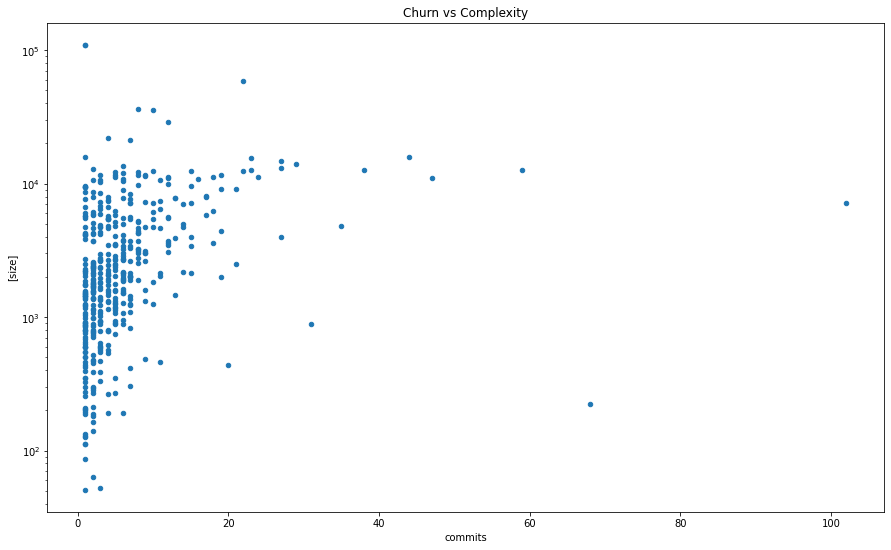

In [24]:
churn_complexity = pandas.merge(churn, complexity, on="filename", suffixes=("_ch", "_co"))
churn_complexity["churn_complexity"] = churn_complexity.apply(lambda row: row["commits"] * row["size"], axis=1)

churn_complexity.plot.scatter(x="commits", y=["size"], title="Churn vs Complexity", figsize=(15,9), logy=True, logx=False)

churn_complexity.sort_values("churn_complexity", ascending=False)[:top]

# Top authors

The authors that contributed most to the repository.

In [25]:
top_authors = df.groupby(['author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors[:top]

,author,commits
0,Arjan Molenaar,1957
1,Dan Yeaw,824
7,dependabot[bot],129
6,allcontributors[bot],43
4,Tiemen Schuijbroek,39
10,pre-commit-ci[bot],39
3,Sourcery AI,16
11,sourcery-ai[bot],7
8,freddii,4
2,Mark Kennedy,3


In [26]:
top_authors_per_package = df.groupby(['dirname', 'author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors_per_package[:top]

,dirname,author,commits
146,gaphor/ui,Arjan Molenaar,238
56,gaphor/UML/classes,Arjan Molenaar,159
91,gaphor/core/modeling,Arjan Molenaar,154
102,gaphor/diagram,Arjan Molenaar,146
16,.github/workflows,Dan Yeaw,97
50,gaphor/UML/actions,Arjan Molenaar,88
34,gaphor/RAAML/fta,Dan Yeaw,87
107,gaphor/diagram/diagramtools,Arjan Molenaar,79
162,packaging,Dan Yeaw,77
1,,Dan Yeaw,74


# Change Coupling

Change coupling tells us which files have a tendency to change together.

In [27]:
def size(iterable):
    return functools.reduce(lambda n, _: n + 1, iterable, 0)

commits = {name: len(commits) for name, commits in df.groupby(["filename"])}

all_file_pairs = sorted(pair for _, group in df.groupby(['commit']) for pair in itertools.combinations(group['filename'], 2))

combos = {pair: size(pairs) for pair, pairs in itertools.groupby(all_file_pairs)}

change_coupling = sorted(((n / (n + commits[a] + commits[b]), n, a, b) for (a, b), n in combos.items()), reverse=1)[:top*5]

rows = (
    f"""
    <tr><td>{n}</td><td>{file_a}</td><td>{commits[file_a]}</td><td>{int(n / commits[file_a] * 100)}</td></tr>
    <tr><td></td><td>{file_b}</td><td>{commits[file_b]}</td><td>{int(n / commits[file_b] * 100)}</td></tr>
    """ for _, n, file_a, file_b in change_coupling)

HTML(f"<table><th><td>Coupled Entities</td><td>Commits</td><td>% coupling</td></th>{''.join(rows)}</table>")

7,gaphor/UML/states/finalstate.py,7,100
,gaphor/UML/states/pseudostates.py,7,100
7,gaphor/RAAML/fta/dormantevent.py,7,100
,gaphor/RAAML/fta/zeroevent.py,7,100
6,gaphor/RAAML/fta/basicevent.py,6,100
,gaphor/RAAML/fta/conditionalevent.py,6,100
5,gaphor/UML/usecases/extend.py,5,100
,gaphor/UML/usecases/include.py,5,100
5,gaphor/UML/actions/flow.py,5,100
,gaphor/UML/states/transition.py,5,100
5,gaphor/UML/actions/actionseditors.py,5,100
